## 협업 필터링을 활용한 추천 시스템 구현

README 파일에서 간단하게 알아본 내용들 중 Collaborate Filtering 기법을 활용하여 추천 시스템을 구현해보자.

지금부터 구현할 내용은 책을 추천하는 시스템을 구현해 볼 것이다.

### 라이브러리 임포트

In [1]:
import os
import re
import nltk
import random
import warnings
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")

### EDA To Popularity based Recommendation system

In [2]:
books = pd.read_csv("./data/Books.csv")
books.head()

ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-L  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...  
3  http://images.amazon.com/images/P/0374157065.0...  
4  http://images.amazon.com/images/P/0393045218.0...

일단 `Books.csv`의 컬럼을 하나씩 보자면,

<center>

|컬럼명|설명|
|:--:|:--:|
|ISBN|고유 바코드 넘버|
|Book-Title|책 제목|
|Book-Author|글쓴이|
|Year-Of-Publication|출판일|
|Publisher|출판사|
|Image-URL-S, M, L|크기순 책 이미지|

</center>

다음으로는 Ratings를 간략하게 보자면,

In [3]:
ratings = pd.read_csv("./data/Ratings.csv")
ratings.head()  # 유저의 고유 아이디, 평점 점수, 바코드 넘버

User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

마지막으로 user정보를 살펴보자면,

In [4]:
users = pd.read_csv("./data/Users.csv")
users.head()  # 마찬가지로 user 고유 id, 사는 위치, 나이가 간단하게 구성되어 있다.

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

In [5]:
print(f"Books shape : {books.shape}")
print(f"Ratings shape : {ratings.shape}")
print(f"Users shape : {users.shape}")

Books shape : (271360, 8)
Ratings shape : (1149780, 3)
Users shape : (278858, 3)


### 결측치 확인

In [6]:
print(f"Any null values in Books: \n {books.isnull().sum()}")
print(f"Any null values in Ratings: \n {ratings.isnull().sum()}")
print(f"Any null values in Users: \n {books.isnull().sum()}")

Any null values in Books: 
 ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
Any null values in Ratings: 
 User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
Any null values in Users: 
 ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


결측치가 조금씩 보이지만, 이따가 한꺼번에 처리하기 위해서 병합부터 실시한다.

### Preprocessing 시작

In [7]:
books_data = books.merge(ratings, on="ISBN")  # ISBM을 기준으로 데이터프레임을 병합한다.
books_data.head()

ISBN           Book-Title           Book-Author Year-Of-Publication  \
0  0195153448  Classical Mythology    Mark P. O. Morford                2002   
1  0002005018         Clara Callan  Richard Bruce Wright                2001   
2  0002005018         Clara Callan  Richard Bruce Wright                2001   
3  0002005018         Clara Callan  Richard Bruce Wright                2001   
4  0002005018         Clara Callan  Richard Bruce Wright                2001   

                 Publisher                                        Image-URL-S  \
0  Oxford University Press  http://images.amazon.com/images/P/0195153448.0...   
1    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
2    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
3    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
4    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0002005018.0...   
3  http://images.amazon.com/images/P/0002005018.0...   
4  http://images.amazon.com/images/P/0002005018.0...   

                                         Image-URL-L  User-ID  Book-Rating  
0  http://images.amazon.com/images/P/0195153448.0...        2            0  
1  http://images.amazon.com/images/P/0002005018.0...        8            5  
2  http://images.amazon.com/images/P/0002005018.0...    11400            0  
3  http://images.amazon.com/images/P/0002005018.0...    11676            8  
4  http://images.amazon.com/images/P/0002005018.0...    41385            0

In [8]:
df = books_data.copy()  # 기존의 데이터를 보존하기 위해서 카피하고,
df.dropna(inplace=True)  # 결측치를 제거하되, 데이터 프레임에도 결과가 동일하게 적용될 수 있도록
df.reset_index(drop=True, inplace=True)  # 제거되는 행 번호를 다시 정렬하기 위해서 인덱스 초기화
df.drop(columns=['ISBN', 'Year-Of-Publication', "Image-URL-S", "Image-URL-M"], axis=1, inplace=True)  # 사용할 열들을 제외한 불필요한 컬럼들은 제거
df.drop(index=df[df['Book-Rating']==0].index, inplace=True)  # 평점이 0인 데이터는 제외하고 사용한다.
df['Book-Title'] = df['Book-Title']
df.head()


Book-Title           Book-Author              Publisher  \
1  Clara Callan  Richard Bruce Wright  HarperFlamingo Canada   
3  Clara Callan  Richard Bruce Wright  HarperFlamingo Canada   
5  Clara Callan  Richard Bruce Wright  HarperFlamingo Canada   
8  Clara Callan  Richard Bruce Wright  HarperFlamingo Canada   
9  Clara Callan  Richard Bruce Wright  HarperFlamingo Canada   

                                         Image-URL-L  User-ID  Book-Rating  
1  http://images.amazon.com/images/P/0002005018.0...        8            5  
3  http://images.amazon.com/images/P/0002005018.0...    11676            8  
5  http://images.amazon.com/images/P/0002005018.0...    67544            8  
8  http://images.amazon.com/images/P/0002005018.0...   116866            9  
9  http://images.amazon.com/images/P/0002005018.0...   123629            9

### Popularity-Based Recommendation System
**인기도 기반 추천**이란, 말 그대로 가장 인기있는 아이템을 추천하는 것을 의미한다. 하지만 `인기도`라는 것은, 추상적인 개념이라 이를 평가할 수 있는 지표가 필요하다.

우리가 인터넷이나 쇼핑몰에서 상품을 고르거나, 혹은 유튜브에서 재밌는 영상을 보려고 할 때 어떤 것들을 고려하는지 생각해보자.

- 상품을 구매하려 한다면 해당 상품의 주문 횟수, 리뷰 등을 고려할 수 있다. 
- 유튜브의 영상을 고를 때는 조회수나 좋아요 수 등을 고려할 수 있다.

### Most Popular - 조회수 기반

조회수가 가장 많은 아이템을 추천해준다. 조회수, 인기(popularity)와 날짜(age)를 조합하여 점수를 만드는 것이 이에 해당된다.

1. Hacker News
    - hacker News의 점수화 알고리즘을 살펴보면 아래와 같다.

    $$score={pageviews-1\over (age+2)^{gravity}} $$

    - 시간(age)이 지날수록 score가 점점 작아지고 : 반비례
    - 조회수(pageviews)가 커질수록 score가 커진다 : 비례
    - gravity는 중력 상수로, 오래된 기사일수록 score값이 작아지도록 조정하는 역할을 한다.

2. Reddit Formula
    - Reddit은 미국의 커뮤니티이다.

    $$score=log_{10}(max(|ups-downs|, 1)) + {(sign(ups-downs)*seconds)\over 45000} $$

    $$sign(x) = \begin{cases}1, \;if\; x > 0 \\ -1, \;if\; x<0 \\0, \;else\; \end{cases}$$

    - ups : 추천 수, downs : 비추천 수
    - 첫 번째 term은 popularity, 두 번쨰 term은 글이 포스팅된 절대 시간을 나타내 준다.
    - 늦게 게시된 포스팅일 수록 더 높은 score를 가진다.

3. 

In [9]:
def popular_books(df, n=100):  # 인기가 있는 책들을 파라미터 n개만큼 가져온다.
    # 책 별 평점을 계산한다.
    rating_count = df.groupby("Book-Title").count()['Book-Rating'].reset_index()
    rating_count.rename(columns={"Book-Rating":"NumberOfVotes"}, inplace=True)

    # 책 별 평균 평점을 계산한다.
    rating_average = df.groupby("Book-Title")['Book-Rating'].mean().reset_index()
    rating_average.rename(columns={"Book-Rating":"AverageRatings"}, inplace=True)

    # 평점 수와 평균 평점을 병합하여
    popular_book_table = rating_count.merge(rating_average, on="Book-Title")
    def weighted_rate(x):
        """
        가중 평점을 계산하는 함수입니다. \n
        C : 전체 책의 평균 평점, \n
        m : 특정 기준(해당 함수에서는 90번 째 백분위수)이상의 평균 점수.
        """
        v = x["NumberOfVotes"]
        R = x["AverageRatings"]

        return ((v*R) + (m*C)) / (v+m)
    
    C = popular_book_table['AverageRatings'].mean()
    m = popular_book_table['NumberOfVotes'].quantile(0.90)

    popular_book_table = popular_book_table[popular_book_table["NumberOfVotes"] >= 250]  # 평점 수가 250 이상인 책을 필터링하고
    popular_book_table["Popularity"] = popular_book_table.apply(weighted_rate, axis=1)  # 가중 평점을 계산하고
    popular_book_table = popular_book_table.sort_values(by="Popularity", ascending=False)  # 정렬한다.

    return popular_book_table[["Book-Title", "NumberOfVotes", "AverageRatings", "Popularity"]].reset_index(drop=True).head(n)

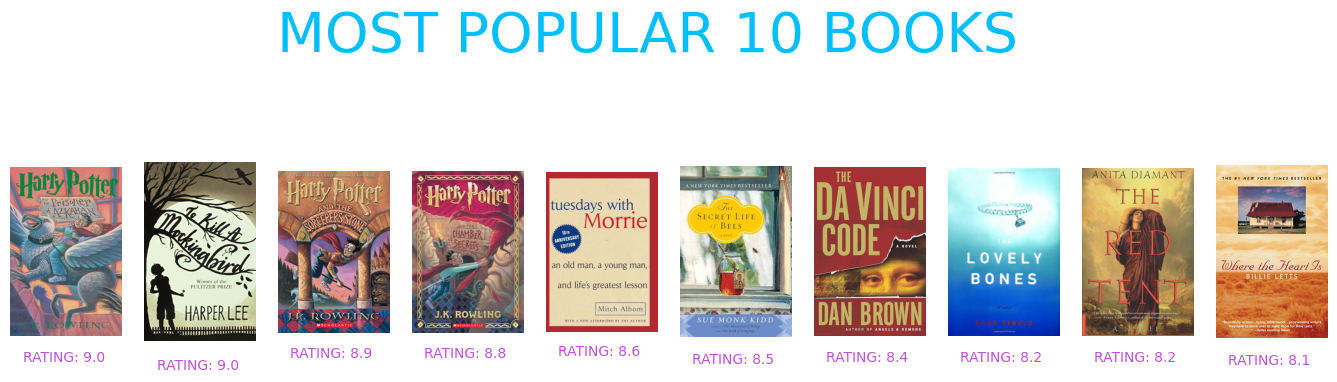

In [10]:
import pandas as pd
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import matplotlib.pyplot as plt

# 403 forbidden error 대비 user-agent header
headers = {"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36"}

n=10
top_ten=pd.DataFrame(popular_books(df,10))  # 상위 10개의 평점에 랭킹된 책을 가져오고
fig,ax=plt.subplots(1,10,figsize=(17,5))  
fig.suptitle("MOST POPULAR 10 BOOKS",fontsize=40,color="deepskyblue")
for i in range(len(top_ten["Book-Title"].tolist())):
    try:
        url = df.loc[df["Book-Title"] == top_ten["Book-Title"].tolist()[i], "Image-URL-L"][:1].values[0]  # 책 표지 이미지 url을 가지고와서
        response = requests.get(url, stream=True, headers=headers)  # request를 보내고
        response.raise_for_status()  # 요청이 성공했는지 확인한 다음
        img = Image.open(BytesIO(response.content))  # PIL로 이미지를 열어서
        ax[i].imshow(img)  # 이미지를 subplot에 배치한다.
        ax[i].axis("off")
        ax[i].set_title(
            "RATING: {} ".format(round(df[df["Book-Title"] == top_ten["Book-Title"].tolist()[i]]["Book-Rating"].mean(), 1)),
            y=-0.20,
            color="mediumorchid",
            fontsize=10
        )
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {url}: {e}")
    except UnidentifiedImageError:
        print(f"Cannot identify image file from {url}")

fig.show()

### Item Based Collaborative filltering

특정 사용자가 좋아할 만한 아이템을 예측하기 위해서 다른 아이템 간의 유사성을 이용하여 추천하는 시스템이다. 주요 개념은 아래와 같다.

1. 아이템(item) : 추천 대상이 되는 객체. 예를 들어, 영화 추천 시스템에서는 영화가 아이템이다.
2. 유사성(Similarity) : 두 아이템 간의 유사도를 측정하는 척도. 일반적으로 코사인 유사도, 피어슨 상관계수, 또는 자카드 유사도 등을 사용한다.
3. 유저(User) : 아이템을 평가하거나 소비하는 사람. 예를 들어, 영화 추천 시스템에서는 영화를 시청하는 사람이 유저가 된다.
4. 평점(Rating) : 유저가 아이템에 대해 부여한 점수. 평점 데이터를 기반으로 유사성을 계산한다.

- 장점
    + 계산이 비교적 간단하며 직관적이다.
    + 유사도가 높은 아이템을 기반으로 추천하므로, 유저에게 의미 있는 추천을 제공할 수 있다.

- 단점
    + 새로운 아이템(콜드 스타트 문제)이나 평점 데이터가 부족한 아이템에 대해 추천을 생성하기 어렵다.
    + 유사도 계산이 아이템의 속성보다는 평점 데이터에 의존하므로, 평점 데이터의 품질이 낮을 경우 추천의 품질도 낮아질 수 있다.

### Workflow

In [25]:
def item_based(book_title):
    book_title = str(book_title)  # 책 제목을 하나 받아서

    if book_title in df['Book-Title'].values:  # 해당 책 제목이 데이터프레임 안에 있는 책이라면
        rating_count = pd.DataFrame(df['Book-Title'].value_counts())  # 평점 개수들을 가지고
        rare_books = rating_count[rating_count['count'] <= 200].index  # 평점 개수가 많이 없는 데이터들과
        common_books = df[~df['Book-Title'].isin(rare_books)]  # 평점 개수가 많은 데이터들을 분리하고

        if book_title in rare_books:  # 만약 평점 개수가 부족한 데이터들에 포함되어 있다면
            most_common = pd.Series(common_books['Book-Title'].unique()).sample(3).values  # 평점 개수가 많은 데이터들 중 랜덤하게 3개를 뽑아서
            print("No Recommendation for this Book 😔 \n")  # 추천해준다.
            print("YOU May Try: \n")
            print(f"{most_common[0]}, \n")
            print(f"{most_common[1]}, \n")
            print(f"{most_common[2]}, \n")
        else:  # 만약 평점 개수가 충분한 데이터들에 포함된다면
            common_books_pivot = common_books.pivot_table(index="User-ID", columns=['Book-Title'], values="Book-Rating")  # 피벗 테이블 형태로 생성해서
            title = common_books_pivot[book_title]  # 사용자가 입력한 제목의 행을 추출해서
            recommendation_df = pd.DataFrame(common_books_pivot.corrwith(title).sort_values(ascending=False)).reset_index(drop=False)  # 상관계수를 계산하고

            # 사용자가 입력한 제목의 데이터를 제외시킨다.
            if book_title in [title for title in recommendation_df["Book-Title"]]:
                recommendation_df=recommendation_df.drop(recommendation_df[recommendation_df["Book-Title"]==book_title].index[0])
                
            less_rating=[]
            for i in recommendation_df["Book-Title"]:  # 책 제목들을 순회하면서
                if df[df["Book-Title"]==i]["Book-Rating"].mean() < 5:  # 평점 평균이 5 미만인 책들을
                    less_rating.append(i)  # 빈 배열에 추가하고
            if recommendation_df.shape[0] - len(less_rating) > 5:  # 만약 추천하려는 책 데이터의 개수가 5권보다 많다면
                recommendation_df=recommendation_df[~recommendation_df["Book-Title"].isin(less_rating)]  # 평점 평균이 낮은 책들은 제외합니다.
                
            recommendation_df=recommendation_df[0:5]  # 5권의 책을 추출해서
            recommendation_df.columns=["Book-Title","Correlation"]  # 책의 이름과 상관계수를 추출합니다.
            
            # 책의 이름과 평점, 상관계수를 기반으로 user에게 5권의 책을 추천합니다.
            fig, ax = plt.subplots(1,5,figsize=(17,5))
            fig.suptitle("WOULD YOU LIKE to TRY THESE BOOKS?",fontsize=40,color="deepskyblue")
            for i in range(len(recommendation_df["Book-Title"].tolist())):
                url=df.loc[df["Book-Title"]==recommendation_df["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
                img=Image.open(requests.get(url,stream=True, headers=headers).raw)
                ax[i].imshow(img)
                ax[i].axis("off")
                ax[i].set_title("RATING: {} ".format(round(df[df["Book-Title"]==recommendation_df["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
                fig.show()
    else:
        print("❌ COULD NOT FIND ❌")


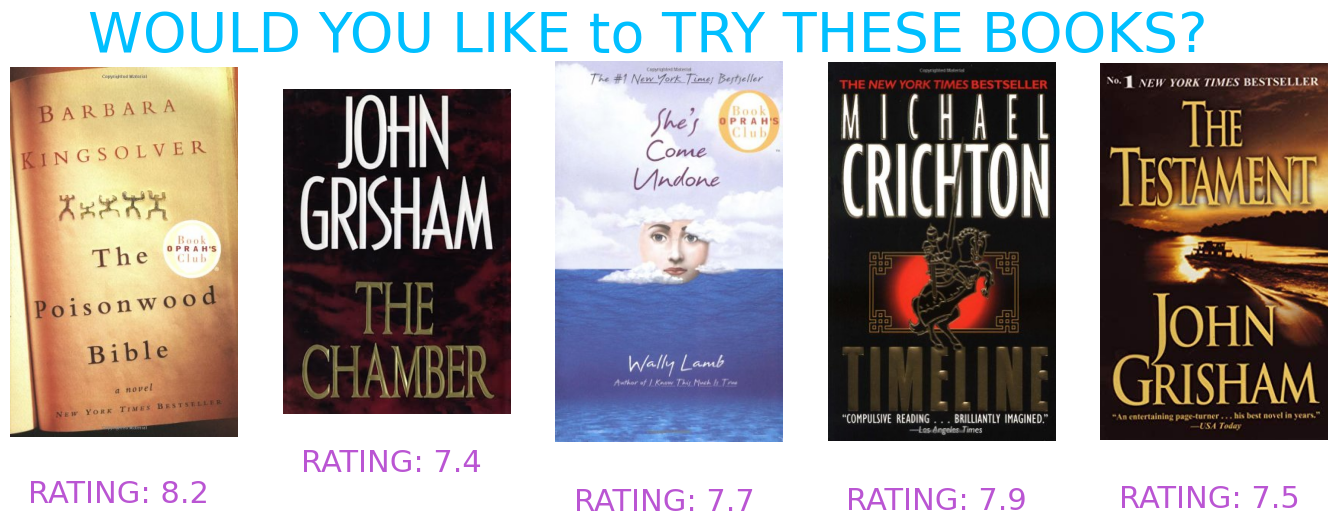

In [26]:
item_based("Me Talk Pretty One Day")

In [27]:
item_based("From One to One Hundred")

No Recommendation for this Book 😔 

YOU May Try: 

Harry Potter and the Chamber of Secrets (Book 2), 

The Testament, 

The Girls' Guide to Hunting and Fishing, 



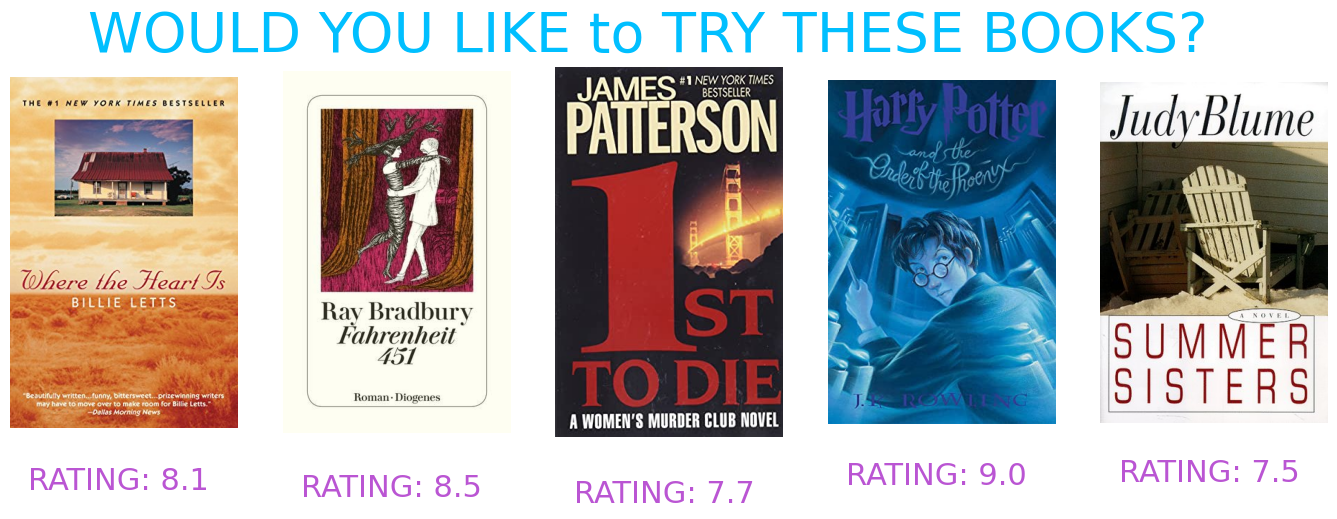

In [28]:
item_based("The Da Vinci Code")

In [29]:
item_based("Barbie")

❌ COULD NOT FIND ❌


### User-Based Collaborative filltering
사용자의 취향을 고려하여 비슷한 취향을 가진 다른 유저들이 선호하는 아이템을 추천하는 방식이다. 주요 개념은 Item Based Collaborative Filltering과 똑같다.

- 장점
    + 사용자의 취향을 직접적으로 반영하여 개인화된 추천을 제공할 수 있다.
    + 계산이 비교적 간단하며 직관적이다.

- 단점
    + 새로운 사용자(콜드 스타트 문제)나 평점 데이터가 부족한 사용자에 대해 추천을 생성하기 어렵다.
    + 사용자 수가 많아질 수록 유사도 계산에 드는 비용이 증가한다.
    + 희소한 데이터에서는 추천의 정확도가 떨어질 수 있다.

### Workflow

In [30]:
new_df = df[df['User-ID'].map(df['User-ID'].value_counts()) > 200]  # 200번 이하로 투표한 유저들은 제외
users_pivot = new_df.pivot_table(index=["User-ID"], columns=["Book-Title"], values="Book-Rating")
users_pivot.fillna(0, inplace=True)

In [31]:
def users_choice(id):
    users_fav = new_df[new_df['User-ID']==id].sort_values(['Book-Rating'], ascending=False)[:5]
    return users_fav

In [38]:
def user_based(new_df, id):
    if id not in new_df["User-ID"].values:
        print("❌ USERS NOT FOUND ❌")
    
    else:
        index = np.where(users_pivot.index==id)[0][0]
        similarity = cosine_similarity(users_pivot)
        similar_users = list(enumerate(similarity[index]))
        similar_users = sorted(similar_users, key=lambda x : x[1], reverse=True)[:5]

        user_rec = []
        for i in similar_users:
            data = df[df['User-ID']==users_pivot.index[i[0]]]
            user_rec.extend(list(data.drop_duplicates("User-ID")['User-ID'].values))
    
        return user_rec


In [40]:
def common(new_df, user, user_id):
    x = new_df[new_df['User-ID']==user_id]
    recommend_books = []
    user_list = list(user)
    for i in user_list:
        y = new_df[(new_df['User-ID']==i)]
        books = y.loc[~y["Book-Title"].isin(x["Book-Title"]), :]
        books = books.sort_values(["Book-Rating"], ascending=False)[:5]
        recommend_books.extend(books['Book-Title'].values)
    return recommend_books[:5]


🟦 USER: 11676


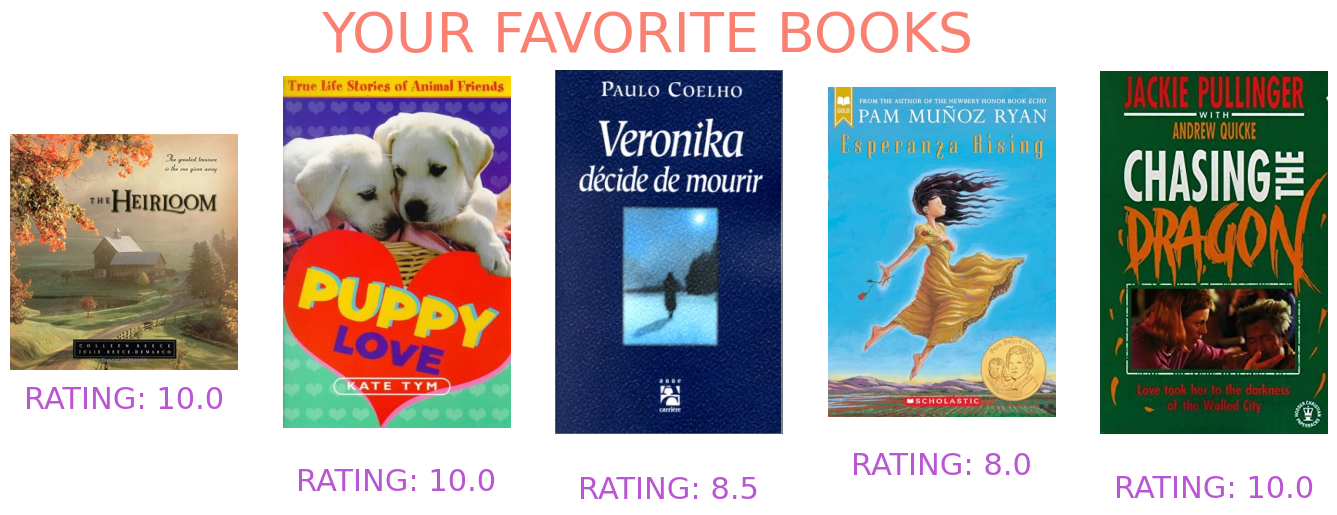

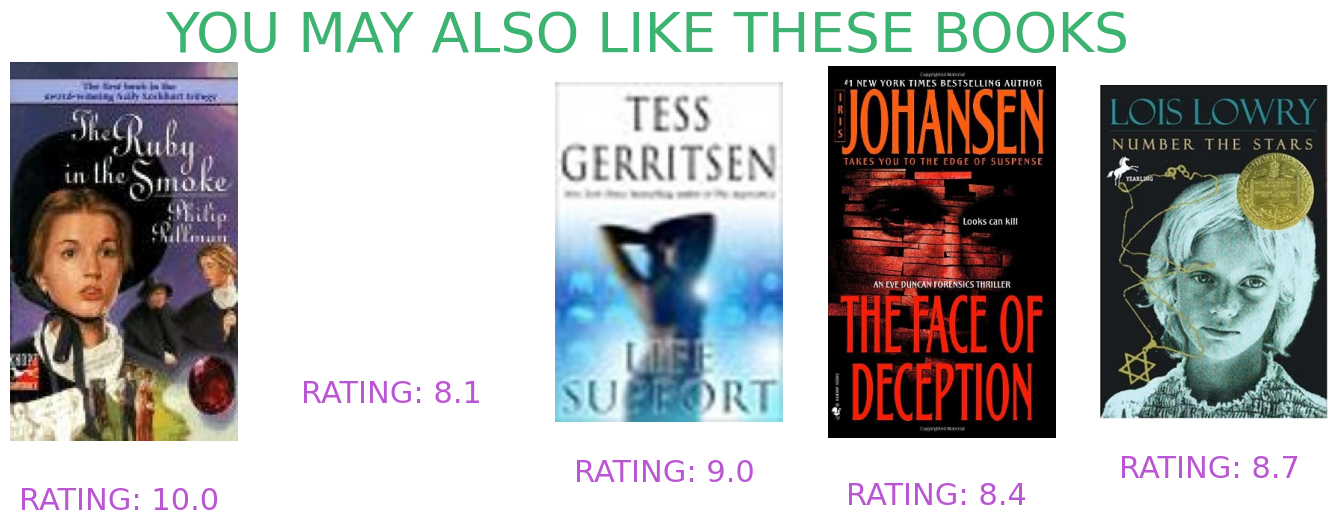

In [42]:
user_id = random.choice(new_df['User-ID'].values)
user_choice_df = pd.DataFrame(users_choice(user_id))
user_favorite = users_choice(user_id)

n = len(user_choice_df["Book-Title"].values)
print(f"🟦 USER: {user_id}")

fig, ax = plt.subplots(1, n, figsize=(17, 5))
fig.suptitle("YOUR FAVORITE BOOKS", fontsize=40, color="salmon")

for i in range(n):
    url = new_df.loc[new_df["Book-Title"]==user_choice_df['Book-Title'].tolist()[i], "Image-URL-L"][:1].values[0]
    img = Image.open(requests.get(url, stream=True, headers=headers).raw)
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title(f"RATING: {round(new_df[new_df['Book-Title']==user_choice_df['Book-Title'].tolist()[i]]['Book-Rating'].mean(), 1)}",
                    y=-0.20, color="mediumorchid", fontsize=22)
    fig.show()

user_based_rec = user_based(new_df, user_id)
books_for_user = common(new_df, user_based_rec, user_id)
books_for_userdf = pd.DataFrame(books_for_user, columns=["Book-Title"])

fig, ax = plt.subplots(1, 5, figsize=(17, 5))
fig.suptitle("YOU MAY ALSO LIKE THESE BOOKS", fontsize=40, color="mediumseagreen")

for i in range(5):
    url = new_df.loc[new_df["Book-Title"]==books_for_userdf['Book-Title'].tolist()[i], "Image-URL-L"][:1].values[0]
    img = Image.open(requests.get(url, stream=True, headers=headers).raw)
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title("RATING: {} ".format(round(new_df[new_df["Book-Title"]==books_for_userdf["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),
                    y=-0.20,color="mediumorchid",fontsize=22)
    fig.show()